## PCA (II): Aplicación a modelado supervisado


Comenzamos importando las librerías que vamos a usar (algunas las repetiremos para que veas donde poder encontrar cada cosa)

In [1]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

from sklearn.decomposition import PCA

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler




En esta sesión vamos a ver como se emplea la PCA en el caso de querer reducir features en un problema de ML, en este caso supervisado.   

### El problema

En concreto, vamos a trabajar con un dataset de información de ciudadanos como el estado civil, número de hijos, qué gastos e ingresos tiene, etc... y el objetivo es decidir si el ciudadano va comprar o a alquilar una vivienda. 


### Cargamos datos de entrada


Como siempre, definido el problema, y supuestamente entendido, cargamos datos y damos nuestro primer vistazo

In [2]:
df = pd.read_csv("data/comprar_alquilar.csv")

df.head(10)

,ingresos,gastos_comunes,pago_coche,gastos_otros,ahorros,vivienda,estado_civil,hijos,trabajo,comprar
0,6000,1000,0,600,50000,400000,0,2,2,1
1,6745,944,123,429,43240,636897,1,3,6,0
2,6455,1033,98,795,57463,321779,2,1,8,1
3,7098,1278,15,254,54506,660933,0,0,3,0
4,6167,863,223,520,41512,348932,0,0,3,1
5,5692,911,11,325,50875,360863,1,4,5,1
6,6830,1298,345,309,46761,429812,1,1,5,1
7,6470,1035,39,782,57439,606291,0,0,1,0
8,6251,1250,209,571,50503,291010,0,0,3,1
9,6987,1258,252,245,40611,324098,2,1,7,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202 entries, 0 to 201
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   ingresos        202 non-null    int64
 1   gastos_comunes  202 non-null    int64
 2   pago_coche      202 non-null    int64
 3   gastos_otros    202 non-null    int64
 4   ahorros         202 non-null    int64
 5   vivienda        202 non-null    int64
 6   estado_civil    202 non-null    int64
 7   hijos           202 non-null    int64
 8   trabajo         202 non-null    int64
 9   comprar         202 non-null    int64
dtypes: int64(10)
memory usage: 15.9 KB


Por lo anterior tenemos varias features numéricas continuas, varias categóricas (entre ellas el target) y algunas numérica discreta.

In [4]:
print(df.columns.to_list())

['ingresos', 'gastos_comunes', 'pago_coche', 'gastos_otros', 'ahorros', 'vivienda', 'estado_civil', 'hijos', 'trabajo', 'comprar']


In [5]:
features_num = ['ingresos', 'gastos_comunes', 'pago_coche', 'gastos_otros', 'ahorros', 'vivienda']
features_cat = ['estado_civil','trabajo']
features_num_discreta = ['hijos']
target = 'comprar'

### Split de train y test


In [6]:

train_set, test_set = train_test_split(df, test_size = 0.2, random_state= 42)

### MiniEDA

Primero la distribuicón del target:

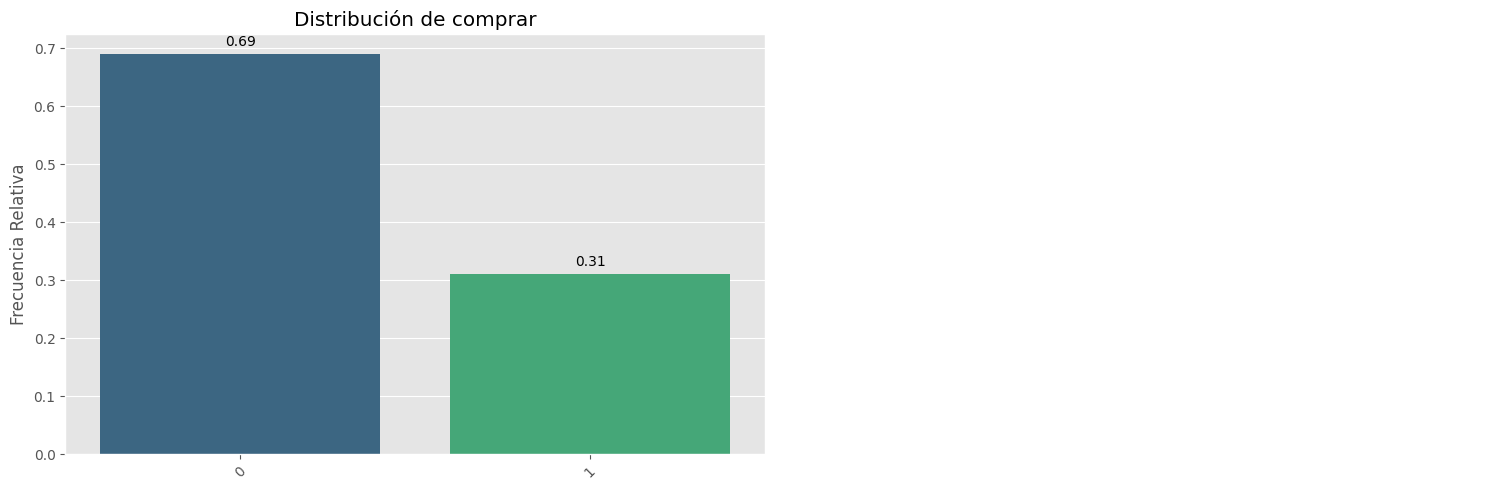

In [7]:
bt.pinta_distribucion_categoricas(train_set, [target], mostrar_valores= True, relativa= True)

Hay un desequilibrio hacia la clase 0, así que decidimos emplear "balanced_accuracy" como métrica.

Para esta sesión no vamos a hacer selección de features manual, vamos a empezar utilizándolas todas, pero como sabemos que sí queremos usar PCA, tendremos que escalar y para ello las variables categóricas tendremos que tratarlas con cuidado. Podemos hacer un one-hot enconding o buscar una codificación ordinal que "tenga sentido".

Para ello, analizamos las categóricas literales contra el target:

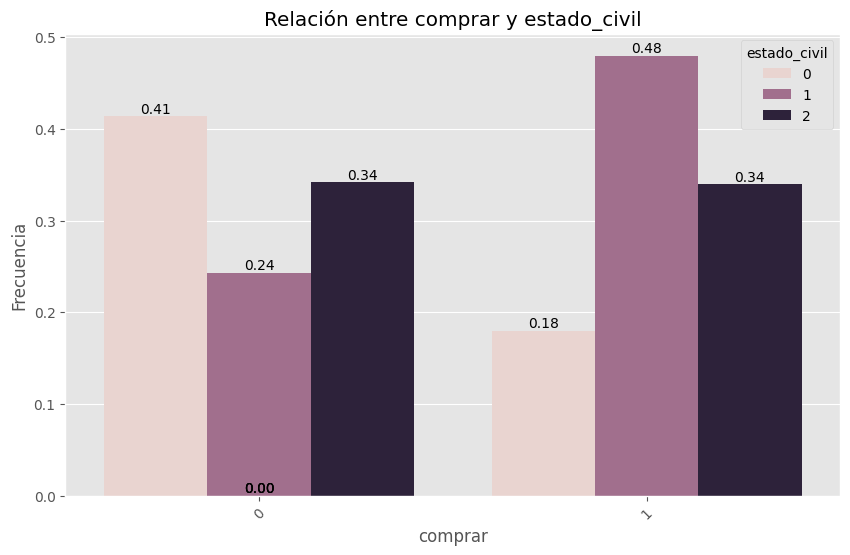

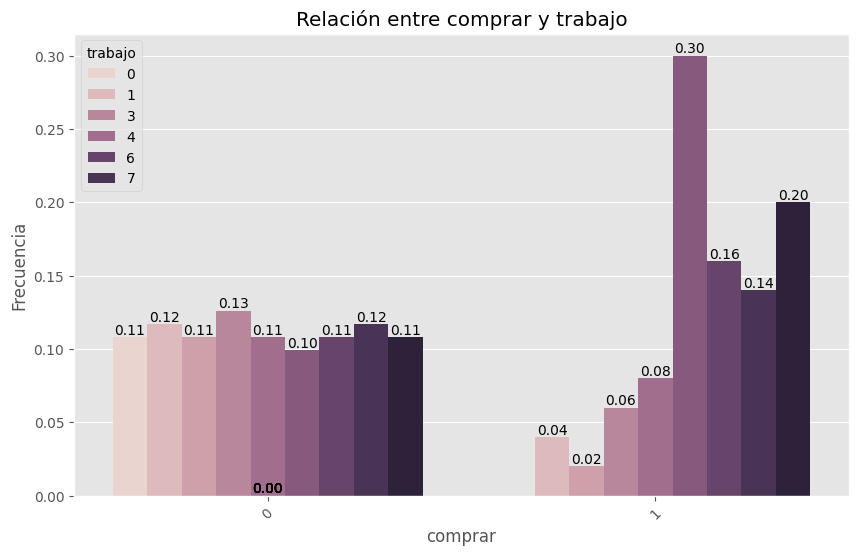

In [8]:
for col in features_cat:
    bt.plot_categorical_relationship_fin(train_set, target, col, relative_freq= True, show_values= True)

En el caso de "estado_civil" podríamos ordenar según la distribución del target == 1 (comprar) es decir 0,2,1. En el caso del trabajo podríamos hacer una ordenación similar (no 0,2,1 sino ordeanda ascendentemente por impacto en 1, a mayor proporción mayor numero de orden). Ambas dos ordenaciones ayudarán al modelo porque a más valor más probabilidad de compra, pero también es un poquito de "sobreajuste". Vamos a aplicar el ordinal a "estado_civil" y el one-hot encoder a "trabajo", aunque podría haber combinado y con tiempo lo más interesante (que no lo más efectivo) habría sido probar todas las posibles combinaciones de codificaciones.

In [9]:
map_estado_civil = {
    0: 0,
    1: 2,
    2: 1
}
train_set["estado_civil"] = train_set["estado_civil"].map(map_estado_civil)
test_set["estado_civil"] = test_set["estado_civil"].map(map_estado_civil)

In [10]:
train_set = pd.get_dummies(train_set, columns = ["trabajo"], dtype = int)
test_set = pd.get_dummies(test_set, columns = ["trabajo"], dtype = int)

### Escalado

Necesitamos escalar (porque vamos a usar la PCA, en un momentito), por simplificar nos saltamos el paso de ver si es bueno transformar alguna de las features

In [11]:
scaler = StandardScaler()
cols = train_set.columns.to_list()
cols.remove(target)
train_set[cols] = scaler.fit_transform(train_set[cols])
test_set[cols] = scaler.transform(test_set[cols])

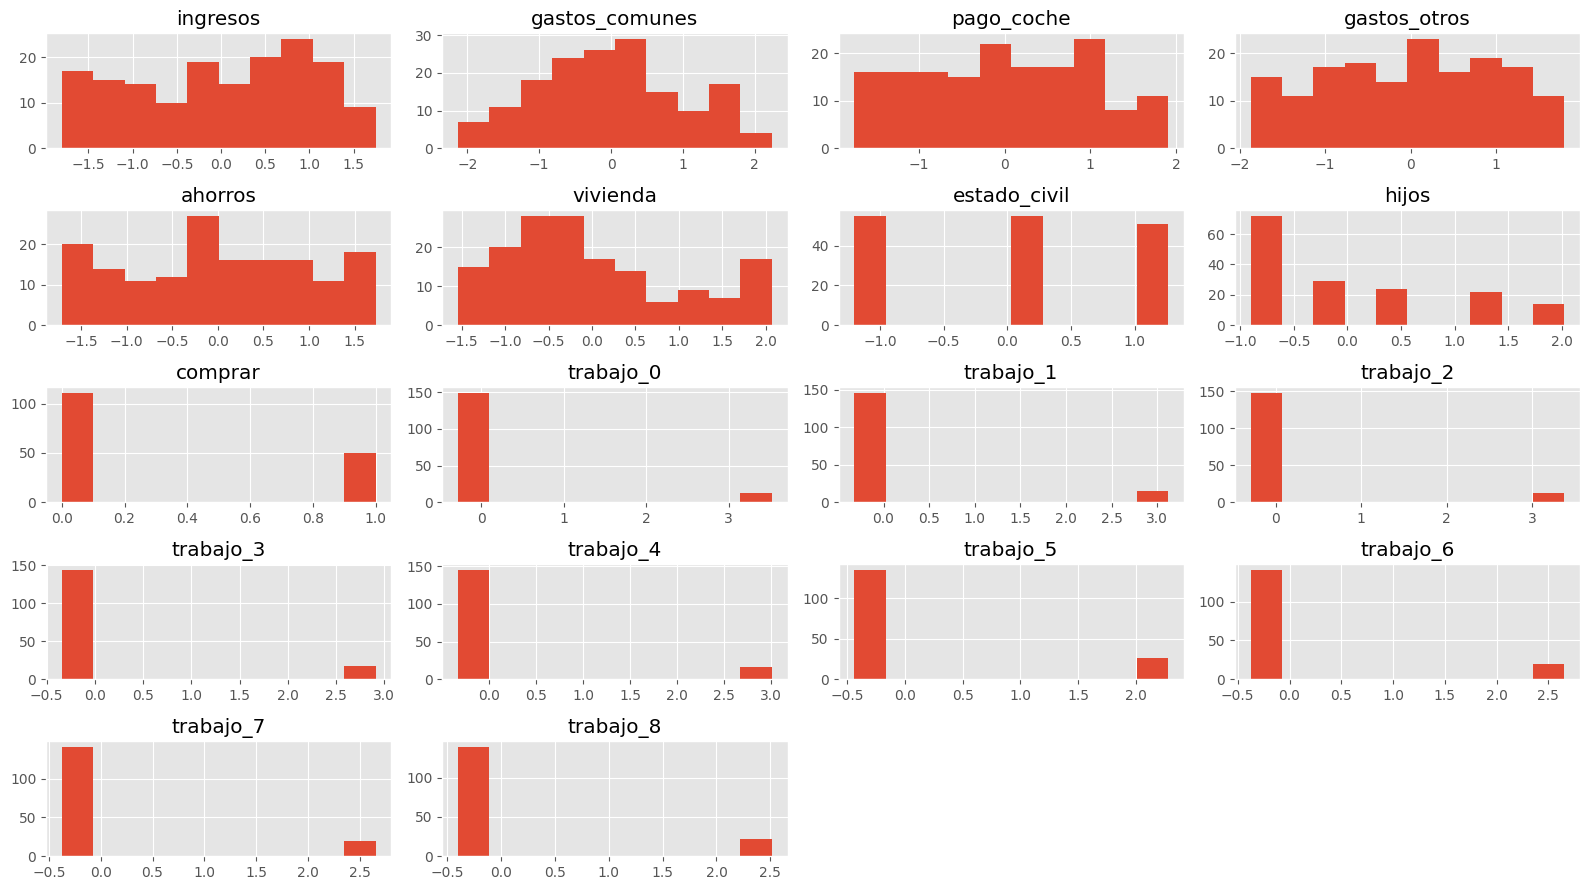

In [12]:
train_set.hist()
plt.tight_layout()

### Entra la PCA

Es el momento de aplicar la PCA para luego jugar con la reducción de features

Primero tenemos que dividir nuestros sets en X,y para no incluir la variable target en la PCA

In [13]:
X_train = train_set.drop(target, axis = 1)
y_train = train_set[target]

X_test = test_set.drop(target, axis = 1)
y_test = test_set[target]

Y ahora aplicamos el modelo de PCA entrenado contra X_train, ojo y ese mismo modelo lo aplicamos al X_test pero sin reentrenarlo (ajustarlo a X_test):

In [14]:
from sklearn.decomposition import PCA 

pca_ml = PCA()
pca_ml.fit(X_train)
X_train_pca = pca_ml.transform(X_train)
X_test_pca = pca_ml.transform(X_test)

Observa que los nuevos X_train_pca y X_test_pca son ahora arrays de numpy, no es problema para sklearn que maneja arrays y dataframes:

In [15]:
X_train_pca

array([[-1.98347721e+00,  1.10631284e+00,  6.53817239e-01, ...,
        -4.60823361e-02, -8.95715211e-01, -2.51607954e-16],
       [-1.02427990e-01,  2.15642908e+00, -1.09891185e+00, ...,
        -5.82466297e-02, -9.26474881e-02, -2.00533375e-16],
       [ 8.20218976e-01, -1.74581464e+00, -6.66122813e-02, ...,
         3.50180891e-01,  4.35391382e-01, -3.67066829e-16],
       ...,
       [-1.31846466e+00, -4.32630890e-01,  1.05395181e+00, ...,
        -5.92205897e-01,  5.17794357e-01, -6.17554970e-17],
       [-4.30500855e-01, -1.68804448e+00,  1.26848832e+00, ...,
         7.84895511e-02, -7.73364235e-01, -5.89111434e-16],
       [ 2.87167800e+00,  9.96366996e-01,  1.72834487e+00, ...,
         2.81998140e-01, -5.88704484e-01, -9.22178341e-16]],
      shape=(161, 17))

Si queremos ver el numero de componentes princpiales (el numero de features de X_train_pca):

In [16]:
X_train_pca.shape

(161, 17)

17, que, como sabíamos y esperábamos, coincide con el número de features originales. 

***

### Analizamos la PCA

Antes de entrenar y comparar debemos escoger el número de componentes (nuevas features o features de X_train_pca) que queremos quedarnos. Para ello haremos el análisis de la varianza atribuible a cada feature igual que hicimos en sesiones pasadas


### Varianza explicada por componente

----------------------------------------------------
Porcentaje de varianza explicada por cada componente
----------------------------------------------------
[1.62584760e-01 1.44991881e-01 7.92190716e-02 7.09796858e-02
 7.05645290e-02 6.75208612e-02 6.67308192e-02 6.56565185e-02
 6.09961543e-02 5.24177720e-02 5.05275078e-02 4.24377553e-02
 2.47495203e-02 1.95679514e-02 1.11165829e-02 9.93862932e-03
 3.28176854e-33]


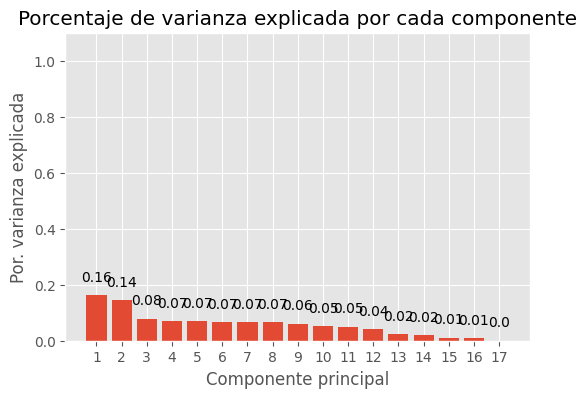

In [17]:
# Porcentaje de varianza explicada por cada componente
# ==============================================================================
print('----------------------------------------------------')
print('Porcentaje de varianza explicada por cada componente')
print('----------------------------------------------------')
print(pca_ml.explained_variance_ratio_)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(pca_ml.n_components_) + 1,
    height = pca_ml.explained_variance_ratio_
)

for x, y in zip(np.arange(len(X_train.columns)) + 1, pca_ml.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(pca_ml.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada');

Podemos ver que vamos a necesitar unas cuantas ya que no hay componentes "dominantes". Veamos el grafico de ratio acumulada para escoger un posible valor inicial de numero de componentes con las que entrenar

### Ratio acumulado de Varianza por la PCA

------------------------------------------
Porcentaje de varianza explicada acumulada
------------------------------------------
[0.16258476 0.30757664 0.38679571 0.4577754  0.52833993 0.59586079
 0.66259161 0.72824813 0.78924428 0.84166205 0.89218956 0.93462732
 0.95937684 0.97894479 0.99006137 1.         1.        ]


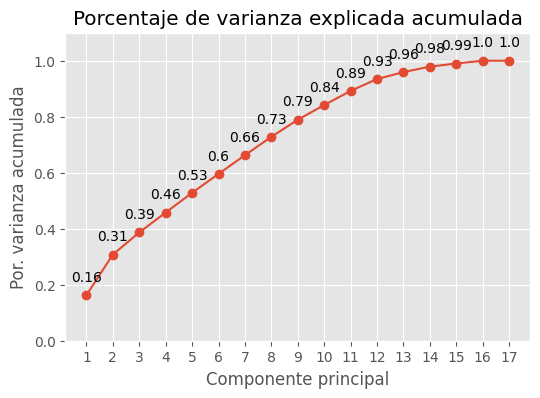

In [18]:
# Porcentaje de varianza explicada acumulada
# ==============================================================================
prop_varianza_acum = pca_ml.explained_variance_ratio_.cumsum()
print('------------------------------------------')
print('Porcentaje de varianza explicada acumulada')
print('------------------------------------------')
print(prop_varianza_acum)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.plot(
    np.arange(len(X_train.columns)) + 1,
    prop_varianza_acum,
    marker = 'o'
)

for x, y in zip(np.arange(len(X_train.columns)) + 1, prop_varianza_acum):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )
    
ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(pca_ml.n_components_) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada');

Viendo la gráfica una regla genérica es no bajar del 85%-90% de la varianza explicada. En este caso tendremos que emplear 11 o más componentes principales. Partiremos de 11 e iremos subiendo para que veas la evolución.

En un ejercicio donde la PCA sea más necesaria (50 o más features, por ejemplo) escogeríamos un rango más limitado en función de la acumulación de varianza y si no nos diera resultado iríamos aumentando el número de componentes (en breve verás exactamente que quiere decir quedarnos con un número de componentes)

### Instanciar y crear modelos sin usar el dataset PCA

Para esta sesión práctica vamos a utilizar una regresión logística, por su sencillez, puedes probar a emplear cualquier otro modelo de clasificación. Lo que haríamos en una situación real es utilizarya directamente el train con pca. Nosotros vamos a emplear un modelo de comparación con todas las features orginales y así ver no sólo como usar la PCA sino ver un punto de comparación con usar todas las features originales (Nota: Ojo esto no quiere decir que siempre sea así, este es un ejemplo muy concreto)

In [19]:
from sklearn.linear_model import LogisticRegression

lr_base = LogisticRegression(max_iter = 1000)
lr_base.fit(X_train, y_train)

lr_clf = LogisticRegression()


param_grid = {
    "max_iter": [1000, 2000, 5000],
    "C": [0.1,1,10],
    "class_weight": ["balanced", None]
}

lr_grid = GridSearchCV(lr_clf,
                       param_grid= param_grid,
                       cv = 4,
                       scoring= "balanced_accuracy")

lr_grid.fit(X_train, y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",LogisticRegression()
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'C': [0.1, 1, ...], 'class_weight': ['balanced', None], 'max_iter': [1000, 2000, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'balanced_accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",4
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 

In [20]:
print(lr_grid.best_params_)

{'C': 10, 'class_weight': 'balanced', 'max_iter': 1000}


Veamos como serían el modelo de comparación y el modelo "tuneado"

In [21]:
print("Baseline, balanced_accuracy:", np.mean(cross_val_score(lr_base, X_train, y_train, scoring = "balanced_accuracy", cv = 4)))
print("Best LR, balanced_accuracy:", lr_grid.best_score_)

Baseline, balanced_accuracy: 0.8879349816849818
Best LR, balanced_accuracy: 0.9221611721611722


Competidores fuertes

### Escogiendo el número de PCAS:


Ahora vamos a buscar el mejor compromiso numero de PCAS/métrica (que es lo que haríamos saltándonos el paso anterior)

In [22]:
lr_pca = LogisticRegression(max_iter = 1000, class_weight= "balanced", C = 10) # Para que pelee en justas condiciones :-)
scores_pca = []
for num_PCs in range(11,18):
    print(f"Probando con {num_PCs} componentes:", sep = " ")
    X_train_pca_reduced = X_train_pca[:,:num_PCs]
    score_pca = np.mean(cross_val_score(lr_pca, X_train_pca_reduced, y_train, cv = 4, scoring = "balanced_accuracy"))
    print(score_pca)
    scores_pca.append(score_pca)




Probando con 11 componentes:
0.7474435286935287
Probando con 12 componentes:
0.717630748880749
Probando con 13 componentes:
0.79255698005698
Probando con 14 componentes:
0.8439789377289377
Probando con 15 componentes:
0.8209706959706959
Probando con 16 componentes:
0.9221611721611722
Probando con 17 componentes:
0.9221611721611722


Graficamente:

Text(0, 0.5, 'Balanced_Accuracy')

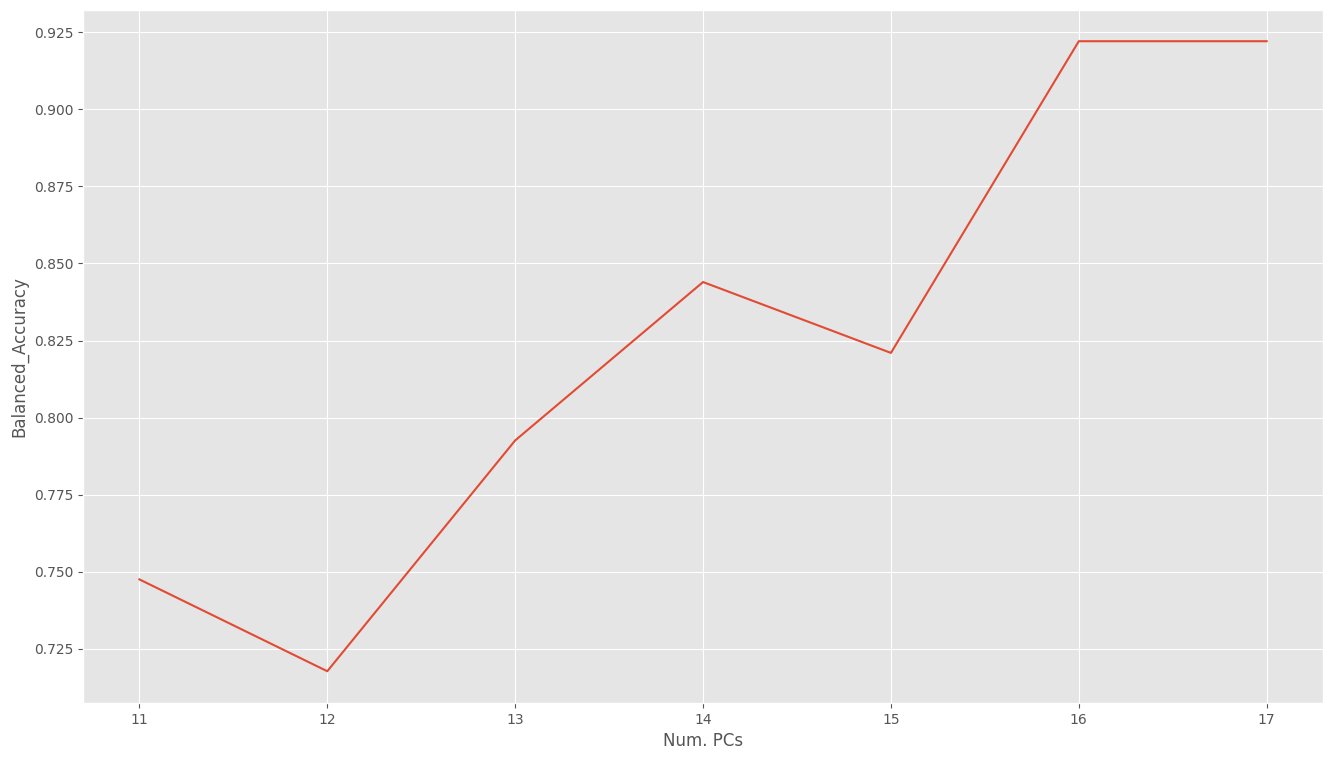

In [23]:
plt.plot(range(11,18),scores_pca)
plt.xlabel("Num. PCs")
plt.ylabel("Balanced_Accuracy")

Los resultados son interesantes por dos motivos:
1. Puede que más PCs no necesariamente den mejor cross-val aunque no sea mucho peor (y puede ser debido al numero de folds) pero también a que estamos hablando de varianza no necesariamente poder informativo.
2. Que no es necesario tener todas las componentes para igualar al modelo con todas las features.

¿Con cuántas PCs nos hubieramos quedado? Depende. Depende de lo que negocio o nosotros consideremos una buen valor para la métrica y un sacrificio asumible (con sólo 11 PCs, estamos perdiendo en validación 17 puntos porcentuales respecto a usar todas, eso sí reduciendo en 6/17 el número de features necesarias)

Una regla genérica puede ser perder un 5% sobre lo mejor a cambio de más de un 20% de features. Si lo mejor en nuestro caso son 92% un resultado de más de 87% con menos de 13-14 features estaría "bien" en términos generales. Nos quedamos ahí, ahí...

### Comparando con test

Para terminar, y por completitud, comparemos con test para 14PCs:

In [24]:
print(classification_report(y_test, lr_grid.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        24
           1       1.00      0.94      0.97        17

    accuracy                           0.98        41
   macro avg       0.98      0.97      0.97        41
weighted avg       0.98      0.98      0.98        41



In [25]:
lr_pca.fit(X_train_pca[:,:15], y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",10
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term

In [26]:
print(classification_report(y_test, lr_pca.predict(X_test_pca[:,:15])))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92        24
           1       0.88      0.88      0.88        17

    accuracy                           0.90        41
   macro avg       0.90      0.90      0.90        41
weighted avg       0.90      0.90      0.90        41



¿Es una reducción aceptable la de usar las 14 PCAS? Depende de:
1. ¿El balanced_accuracy (recall medio, o macro avg recall) es bueno para PCA 14? (Ojo, empleamos esta métrica en este problema, tendrás que emplear la métrica correspondiente en cada problema)
2. Si lo es para negocio, ¿es aceptable tener que explicar el modelo recurriendo a interpretar las PCAS sobre las features? Es decir, ¿es aceptable tener una interpretabilidad peor?

Si las respuestas son sí, entonces perfecto siempre obtendremos las PCA de nuestro dataset de entrada. Pero ojo, que hayamos reducido las features del modelo en este caso no quiere decir que hayamos reducido nuestra necesidad en los datos de entrada, ya que cada PCA requiere de todos los datos originales para ser calculada.